#Human Activity Recognition


This data has been released by the Wireless Sensor Data Mining
(WISDM) Lab. <http://www.cis.fordham.edu/wisdm/>

The data in this file corrispond with the data used in the
following paper:

Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). 
Activity Recognition using Cell Phone Accelerometers, 
Proceedings of the Fourth International Workshop on Knowledge 
Discovery from Sensor Data (at KDD-10), Washington DC. 
<http://www.cis.fordham.edu/wisdm/public_files/sensorKDD-2010.pdf>

Sampling rate: 
20Hz (1 sample every 50ms) --> every 0,05s

Fields:

*user
	nominal, 1..36

*activity
	nominal, {
		Walking
		Jogging
		Sitting
		Standing
		Upstairs
		Downstairs }

*timestamp
	numeric, generally the phone's uptime in nanoseconds
		(In future datasets this will be miliseconds
		since unix epoch.)

*x-acceleration
	numeric, floating-point values between -20 .. 20
		The acceleration in the x direction as measured
		by the android phone's accelerometer. 
		A value of 10 = 1g = 9.81 m/s^2, and
		0 = no acceleration.
		The acceleration recorded includes gravitational
		acceleration toward the center of the Earth, so
		that when the phone is at rest on a flat surface
		the vertical axis will register +-10. 

*y-accel
	numeric, see x-acceleration

*z-accel
        numeric, see x-acceleration


In [ ]:
%reset  

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
!pip install keras==2.4.3

In [ ]:
import seaborn as sns
import plotly.express
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
pd.options.mode.chained_assignment = None
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPool1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
print(keras.__version__)

2.4.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
columns = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/My Drive/Dataset/dataset/activityprediction/WISDM_ar_v1.1_raw.txt',
                     header=None,
                     sep=',',
                     names=columns)

#Data preprocessing



In [ ]:
df['z-axis'].replace(';','',regex=True, inplace=True)
df['z-axis']=df['z-axis'].astype('float64')
df.isna().any()
print(df.shape)
df=df.dropna()

(1098204, 6)


In [ ]:
sorted_df = df.sort_values(by=['activity','user-id','timestamp'])
sorted_df = sorted_df.drop(sorted_df[sorted_df['timestamp']==0].index)
sorted_df[sorted_df['timestamp']==0]
labelencoder = LabelEncoder()
sorted_df['labels'] = labelencoder.fit_transform(sorted_df['activity'])

In [ ]:
pd.crosstab(sorted_df['activity'],sorted_df['user-id'])

user-id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
activity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Downstairs,2941,0,3326,1761,3281,1431,2257,3345,0,3792,2674,2870,4241,2875,1762,1575,3767,2410,2613,4673,4036,3625,1939,2929,0,3837,3442,2997,4265,3872,3892,2208,4535,2856,0,4167
Jogging,11056,11786,11018,895,6405,10961,9183,10313,0,12084,12454,12360,11301,13279,10798,0,2887,10911,16201,10728,9593,6224,12309,12278,6489,11913,10856,0,11458,0,14075,10249,2946,12869,12564,11887
Sitting,0,0,1609,1257,1664,1679,2529,2699,0,0,0,2289,1179,0,0,2984,0,1467,2534,15644,1609,0,0,690,0,0,2099,0,2319,1559,2148,3059,3248,1575,1599,2500
Standing,0,0,2824,0,1515,709,2364,3269,0,1659,0,1670,1659,0,0,1979,0,1954,2132,5389,2859,0,0,544,0,0,1630,1300,1603,3099,2612,1669,1612,1349,1069,1925
Upstairs,3120,0,3411,1377,3387,1661,3601,4453,0,4294,4392,2654,4637,8179,2055,1411,5689,2409,4280,4833,4841,5430,4836,3039,0,3618,3064,2892,4769,4226,4679,3797,2214,3921,0,5429
Walking,12861,11739,12970,6079,12257,12262,11033,17108,12923,13046,12138,10798,13047,13859,11467,12521,9677,12554,17622,13027,12498,7029,6589,6256,6979,13210,12366,14169,12354,12579,16876,12375,14898,13377,7162,6200


In [ ]:
#dividing data for training and test sets
sorted_train = sorted_df[sorted_df['user-id']<=29]
sorted_test = sorted_df[sorted_df['user-id']>29]

In [ ]:
#setting constants for networks
TIME_INTERVAL = 80
OVERLAP = 50
INPUT_DIM = 3 

In [ ]:
dict_of_activities_tr = {}
dict_of_activities_te = {}
def activity_split(dict_data, dataframe):
  '''
  creating dictionaries of certain activity 
  connected with its measurements
    Parameters:
      dict_data (dict): A dictionary to be filled 
      dataframe (dataframe): A dataframe of testing or training data
  '''
  for activity in dataframe.activity.unique():
    dict_data[activity] = (dataframe[dataframe['activity']==activity])

In [ ]:
activity_split(dict_of_activities_tr, sorted_train)
activity_split(dict_of_activities_te, sorted_test)

In [ ]:
def data_preprocessing(activity_df, interval, step):
  '''
  dividing data for neural network training
  and creating list of x, y, z mesurements 
  and list containing labels
    Prameters:
      activity_df (dataframe): A dataframe of testing or training data
      interval (int): Integer value of samples per axis
      step (int): Integer value of overlap 
    Returns:
      t_dataset (list): A list of measurements
      t_labels (list): A list of labels
  '''
  t_dataset = []
  t_labels = []
  for data in range(0, len(activity_df)-interval, step):
    x = activity_df['x-axis'].values[data: data + interval]
    y = activity_df['y-axis'].values[data: data + interval] 
    z = activity_df['z-axis'].values[data: data + interval]
  
    t_dataset.append(np.concatenate([x,y,z]))
    t_labels.append(activity_df['labels'].values[data])

  return t_dataset, t_labels

In [ ]:
def data_dividing(sorted_activity_dict):
  '''
  creating sets X and Y training and test sets
    Prameters:
      sorted_activity_dict (dict): Dictionaries containing test 
      or training sets
    Returns:
      activity_dataset (list): List containing X training or test set
      activity_labels (list): List containing Y training or test set
  '''
  activity_dataset = []
  activity_labels = []
  sorted_np = sorted_activity_dict['timestamp'].to_numpy()
  inserted_zeros = np.insert(sorted_np, 0, 0, axis=0)
  sorted_np = np.append(sorted_np,[0])
  done_values=abs(sorted_np-inserted_zeros)
  end_val = (np.argwhere(done_values>500000000))
  end_val = np.squeeze(end_val)

  for el in range(len(end_val)-1):
    t_dataset, t_labels = data_preprocessing(
        sorted_activity_dict.iloc[end_val[el]:end_val[el+1]],
                                             TIME_INTERVAL, OVERLAP)  
    activity_dataset.extend(t_dataset)
    activity_labels.extend(t_labels)
  return activity_dataset, activity_labels

In [ ]:
X_train = []
X_test = [] 
y_train = [] 
y_test = []

for i in dict_of_activities_te.keys():
  activity_dataset, activity_labels = data_dividing(dict_of_activities_te[i])
  X_test.extend(activity_dataset)
  y_test.extend(activity_labels)

for j in dict_of_activities_tr.keys():
  activity_dataset, activity_labels = data_dividing(dict_of_activities_tr[j])
  X_train.extend(activity_dataset)
  y_train.extend(activity_labels)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_train = np_utils.to_categorical(y_train, num_classes=6)

In [ ]:
y_test = np_utils.to_categorical(y_test, num_classes=6)

In [ ]:
#spliting datasets in order to shuffle them
train = []
test= []

train = list(zip(X_train,y_train))
test = list(zip(X_test,y_test))

random.shuffle(train)
random.shuffle(test)

In [ ]:
#reconnecting datasets
train = list(map(list, zip(*train)))
test = list(map(list, zip(*test)))

X_train = np.array(train[0])
y_train = np.array(train[1])
X_test = np.array(test[0])
y_test = np.array(test[1])

#First model

In [ ]:
INPUT = INPUT_DIM*TIME_INTERVAL

In [ ]:
#first model
model = Sequential()
model.add(Dense(100, input_shape = (INPUT,), activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                      y_train,
                      epochs = 50,
                      validation_split=0.2,
                      verbose=2)

Epoch 1/50
421/421 - 1s - loss: 0.9205 - accuracy: 0.6602 - val_loss: 0.5385 - val_accuracy: 0.7900
Epoch 2/50
421/421 - 1s - loss: 0.5296 - accuracy: 0.8001 - val_loss: 0.4285 - val_accuracy: 0.8314
Epoch 3/50
421/421 - 1s - loss: 0.4349 - accuracy: 0.8297 - val_loss: 0.3916 - val_accuracy: 0.8483
Epoch 4/50
421/421 - 1s - loss: 0.3734 - accuracy: 0.8516 - val_loss: 0.3810 - val_accuracy: 0.8531
Epoch 5/50
421/421 - 1s - loss: 0.3230 - accuracy: 0.8669 - val_loss: 0.3680 - val_accuracy: 0.8581
Epoch 6/50
421/421 - 1s - loss: 0.2955 - accuracy: 0.8738 - val_loss: 0.3513 - val_accuracy: 0.8736
Epoch 7/50
421/421 - 1s - loss: 0.2588 - accuracy: 0.8886 - val_loss: 0.3724 - val_accuracy: 0.8795
Epoch 8/50
421/421 - 1s - loss: 0.2374 - accuracy: 0.8970 - val_loss: 0.3945 - val_accuracy: 0.8697
Epoch 9/50
421/421 - 1s - loss: 0.2247 - accuracy: 0.9026 - val_loss: 0.3623 - val_accuracy: 0.8858
Epoch 10/50
421/421 - 1s - loss: 0.2045 - accuracy: 0.9108 - val_loss: 0.3915 - val_accuracy: 0.8733

In [ ]:
print(model.summary())

In [ ]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.save('model_1.h5')

In [ ]:
print(model.evaluate(X_test, y_test))

136/136 [==============================] - 0s 2ms/step - loss: 1.3807 - accuracy: 0.7921
[1.380730390548706, 0.7920883297920227]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       404
           1       0.81      0.89      0.85      1269
           2       0.96      0.91      0.93       306
           3       0.86      0.94      0.90       258
           4       0.48      0.58      0.53       460
           5       0.89      0.81      0.85      1651

    accuracy                           0.79      4348
   macro avg       0.76      0.76      0.76      4348
weighted avg       0.80      0.79      0.79      4348



In [ ]:
confusion_matrix(y_test, y_pred)
# 0-Downstairs
# 1-Jogging
# 2-Sitting
# 3-Standing
# 4-Upstairs
# 5-Walking

array([[ 183,   28,    1,    6,  109,   77],
       [  32, 1124,    0,    0,   88,   25],
       [   0,    0,  277,   17,   12,    0],
       [   2,    0,   11,  243,    2,    0],
       [  66,   45,    1,   18,  269,   61],
       [  54,  186,    0,    0,   75, 1336]])

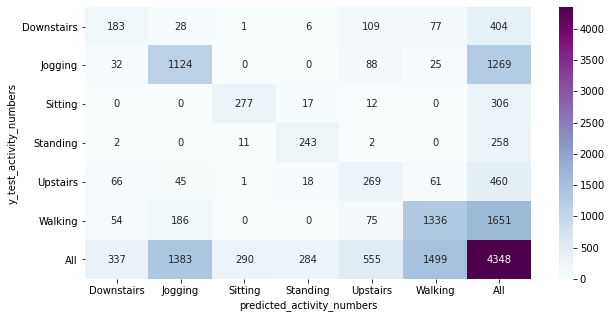

In [ ]:
plt.figure(figsize=(10,5))
confusion_matrix_df = pd.crosstab(y_test, y_pred, rownames=['y_test_activity_numbers'], colnames=['predicted_activity_numbers'], margins = True)
sns.heatmap(confusion_matrix_df, annot=True,  cmap="BuPu", fmt='d',yticklabels=(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking','All']), xticklabels=(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking', 'All']))
plt.show()

#Second model

In [ ]:
INPUT = INPUT_DIM*TIME_INTERVAL

In [ ]:
#second model
model2 = Sequential()
model2.add(Reshape((TIME_INTERVAL, INPUT_DIM), input_shape=(INPUT,)))
model2.add(Conv1D(240, 10, activation='relu', input_shape=(TIME_INTERVAL,
                                                           INPUT_DIM)))
model2.add(Conv1D(80, 10, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(160, 10, activation='relu'))
model2.add(Conv1D(80, 10, activation='relu'))
model2.add(Dropout(0.5))
model2.add(GlobalAveragePooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(6, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model2.fit(X_train,
                      y_train,
                      batch_size = 128,
                      epochs = 15,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/15
106/106 [==============================] - 1s 12ms/step - loss: 0.8403 - accuracy: 0.6929 - val_loss: 0.5343 - val_accuracy: 0.8001
Epoch 2/15
106/106 [==============================] - 1s 7ms/step - loss: 0.4991 - accuracy: 0.8188 - val_loss: 0.3855 - val_accuracy: 0.8635
Epoch 3/15
106/106 [==============================] - 1s 7ms/step - loss: 0.3710 - accuracy: 0.8626 - val_loss: 0.3301 - val_accuracy: 0.8929
Epoch 4/15
106/106 [==============================] - 1s 7ms/step - loss: 0.2953 - accuracy: 0.8958 - val_loss: 0.2412 - val_accuracy: 0.9328
Epoch 5/15
106/106 [==============================] - 1s 7ms/step - loss: 0.2320 - accuracy: 0.9242 - val_loss: 0.1812 - val_accuracy: 0.9539
Epoch 6/15
106/106 [==============================] - 1s 7ms/step - loss: 0.1934 - accuracy: 0.9384 - val_loss: 0.1598 - val_accuracy: 0.9485
Epoch 7/15
106/106 [==============================] - 1s 7ms/step - loss: 0.1698 - accuracy: 0.9431 - val_loss: 0.1749 - val_accuracy: 0.9474
Epoch

In [ ]:
keras.utils.plot_model(model2, to_file='model2_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.save('model_2.h5')

In [ ]:
model2.evaluate(X_test, y_test)

136/136 [==============================] - 0s 4ms/step - loss: 0.5542 - accuracy: 0.8834


[0.5541906356811523, 0.8833946585655212]

In [ ]:
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#y_test= np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       404
           1       0.99      0.94      0.96      1269
           2       0.78      0.96      0.86       306
           3       0.98      0.66      0.79       258
           4       0.72      0.77      0.74       460
           5       0.92      0.94      0.93      1651

    accuracy                           0.88      4348
   macro avg       0.84      0.82      0.83      4348
weighted avg       0.89      0.88      0.88      4348



In [ ]:
confusion_matrix(y_test, y_pred)
# 0-Downstairs
# 1-Jogging
# 2-Sitting
# 3-Standing
# 4-Upstairs
# 5-Walking

array([[ 333,    1,    0,    0,   25,   45],
       [  21, 1158,    0,    0,   53,   37],
       [   0,    0,  276,    0,   30,    0],
       [   1,    0,   88,  160,    9,    0],
       [  85,   15,    0,    1,  315,   44],
       [ 126,    0,    0,    0,    1, 1524]])

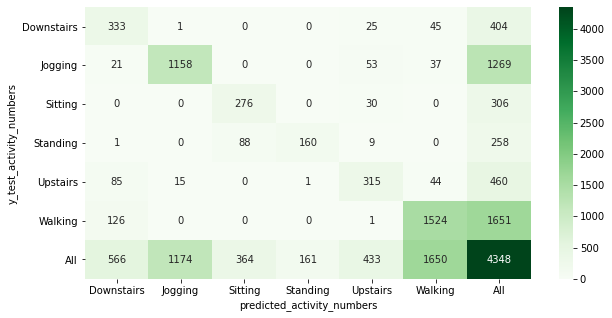

In [ ]:
plt.figure(figsize=(10,5))
confusion_matrix_df = pd.crosstab(y_test, y_pred, rownames=['y_test_activity_numbers'], colnames=['predicted_activity_numbers'], margins = True)
sns.heatmap(confusion_matrix_df, annot=True,  cmap="Greens", fmt='d',yticklabels=(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking','All']), xticklabels=(['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking', 'All']))
plt.show()

#Data representation

#WISDM Dataset
Fields:

*user
	nominal, 1..36

*activity
	nominal, {
		Walking
		Jogging
		Sitting
		Standing
		Upstairs
		Downstairs }

*timestamp
	numeric, generally the phone's uptime in nanoseconds
		(In future datasets this will be miliseconds
		since unix epoch.)

*x-acceleration
	numeric, floating-point values between -20 .. 20
		The acceleration in the x direction as measured
		by the android phone's accelerometer. 
		A value of 10 = 1g = 9.81 m/s^2, and
		0 = no acceleration.
		The acceleration recorded includes gravitational
		acceleration toward the center of the Earth, so
		that when the phone is at rest on a flat surface
		the vertical axis will register +-10. 

*y-accel
	numeric, see x-acceleration

*z-accel
        numeric, see x-acceleration


In [ ]:
sns.set()

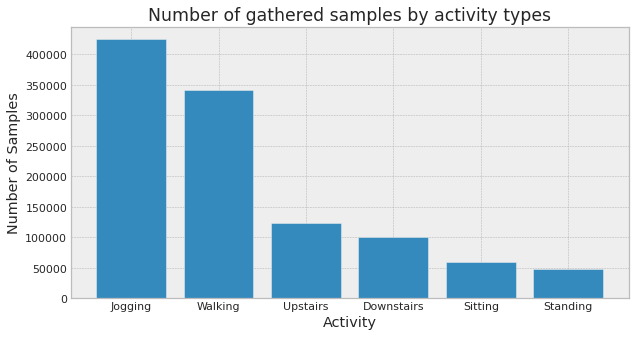

In [ ]:
plt.figure(figsize= (10,5))
plt.style.use('bmh')
plt.bar(df.activity.unique(),df['activity'].value_counts())
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.title('Number of gathered samples by activity types')
plt.show()

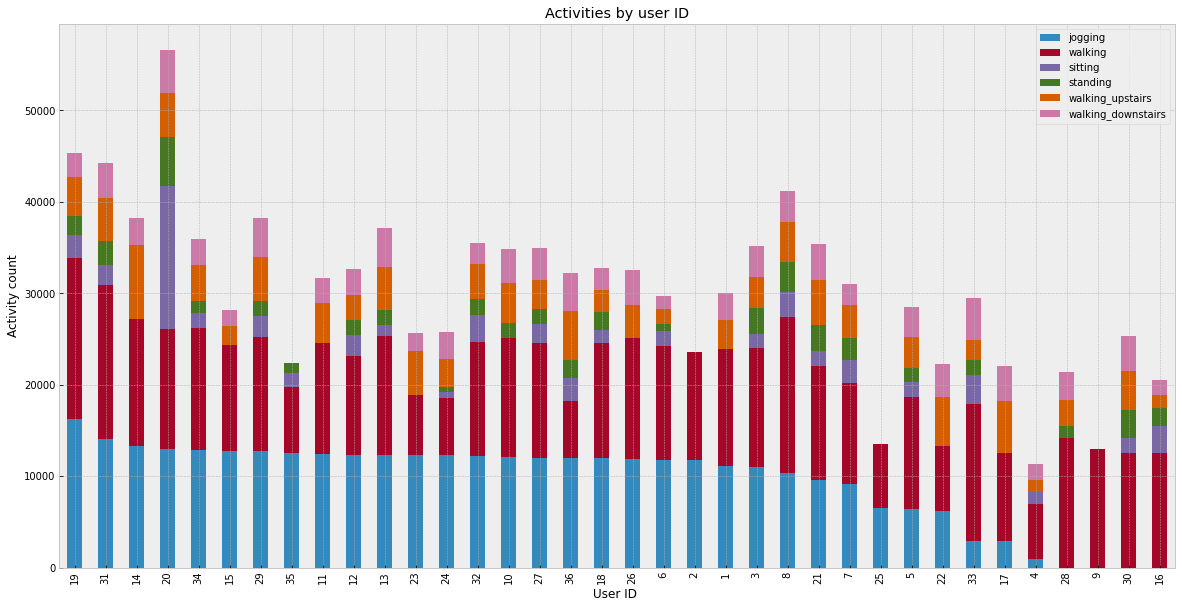

In [ ]:
jog = df[df['activity']=='Jogging']
walk = df[df['activity']=='Walking']
down = df[df['activity']=='Downstairs']
up = df[df['activity']=='Upstairs']
sit = df[df['activity']=='Sitting']
stand = df[df['activity']=='Standing']

A = jog['user-id'].value_counts()
B = walk['user-id'].value_counts()
C = sit['user-id'].value_counts()
D= stand['user-id'].value_counts()
E= up['user-id'].value_counts()
F = down['user-id'].value_counts()

A = dict(A)
B = dict(B)
C = dict(C)
D = dict(D)
E = dict(E)
F = dict(F)

all = dict(jogging = A, walking = B, sitting = C, standing = D, walking_upstairs = E,  walking_downstairs = F)

graph = pd.DataFrame(all)
graph.plot(figsize = (20,10), kind='bar', stacked=True, use_index=True)
plt.title('Activities by user ID')
plt.xlabel('User ID ')
plt.ylabel('Activity count')
plt.show()

In [ ]:
def data_rep(time):
  n_samples= time*20 #20Hz sampling rate
  return n_samples

Text(0.5, 1.0, 'Jogging x')

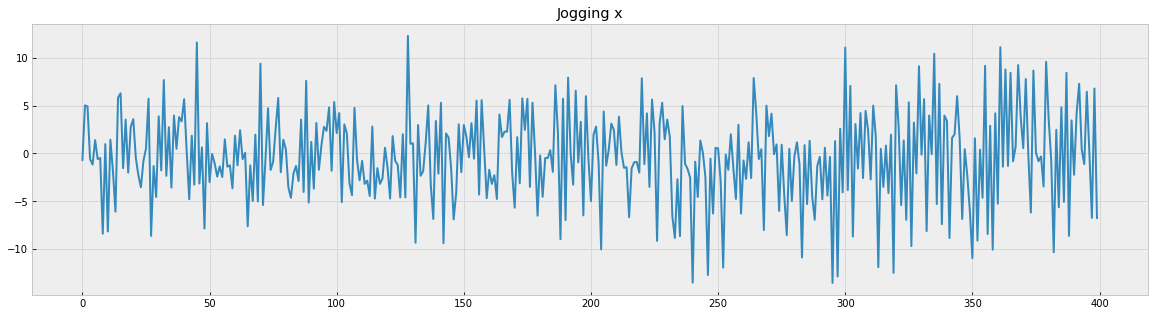

In [ ]:
n_samples=data_rep(20)
plt.figure(figsize=(20,5))
plt.plot(jog['x-axis'][:n_samples])
plt.title('Jogging x')

Text(0.5, 1.0, 'Jogging y')

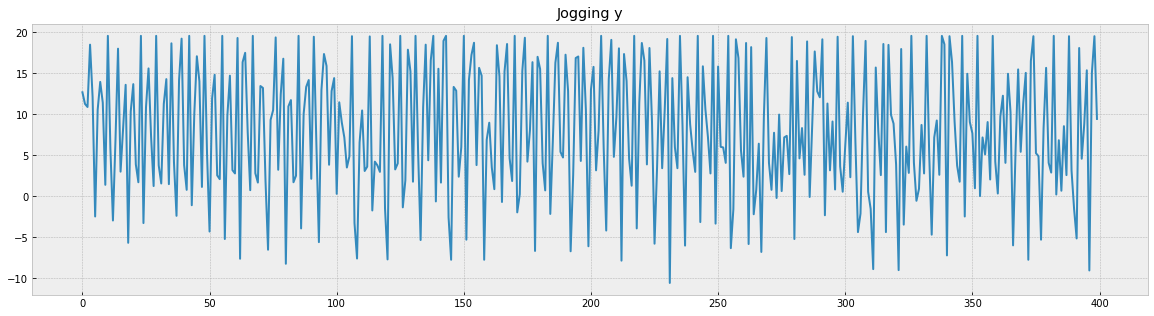

In [ ]:
n_samples=data_rep(20)
plt.figure(figsize=(20,5))
plt.plot(jog['y-axis'][:n_samples])
plt.title('Jogging y')

Text(0.5, 1.0, 'Jogging z')

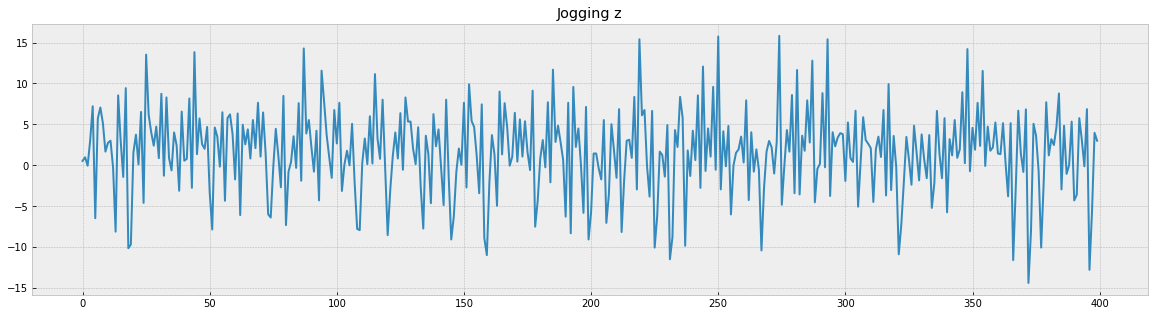

In [ ]:
n_samples=data_rep(20)
plt.figure(figsize=(20,5))
plt.plot(jog['z-axis'][:n_samples])
plt.title('Jogging z')

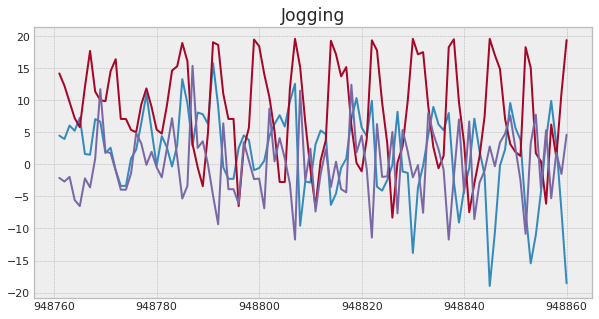

In [ ]:
n_samples=data_rep(5) #5 seconds
plt.figure(figsize=(20,5))
plt.plot(jog['x-axis'][:n_samples])
plt.plot(jog['y-axis'][:n_samples])
plt.plot(jog['z-axis'][:n_samples])
plt.title('Jogging')

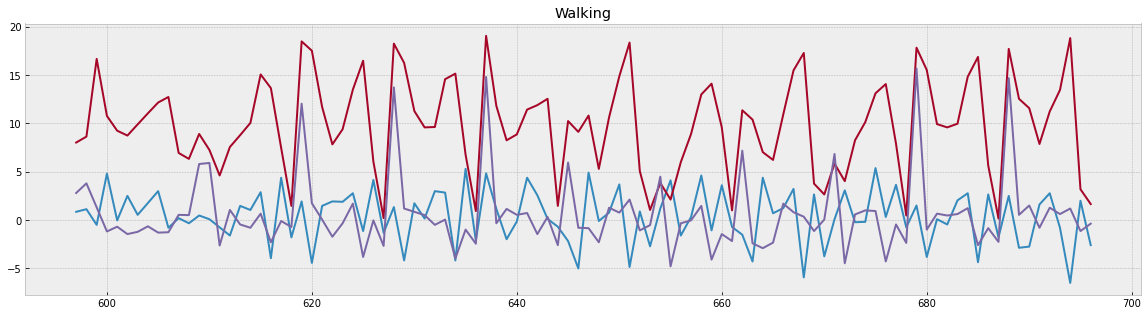

In [ ]:
n_samples=data_rep(5) #5 seconds
plt.figure(figsize=(20,5))
plt.plot(walk['x-axis'][:n_samples])
plt.plot(walk['y-axis'][:n_samples])
plt.plot(walk['z-axis'][:n_samples])
plt.title('Walking')


Text(0.5, 1.0, 'Standing')

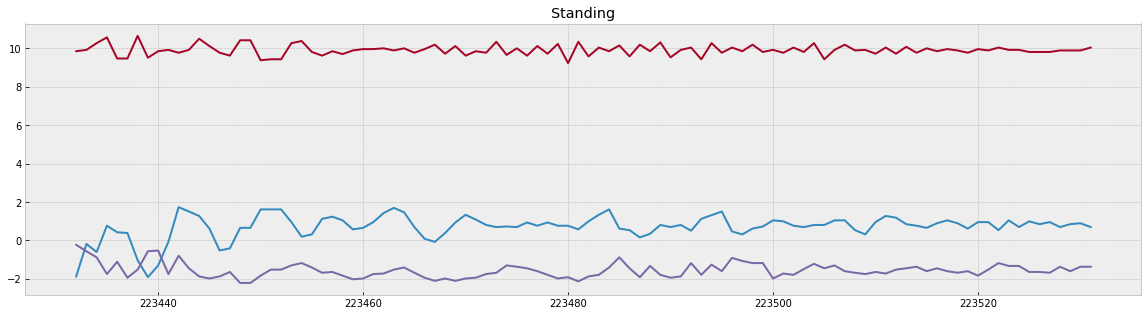

In [ ]:
n_samples=data_rep(5) #5 seconds
plt.figure(figsize=(20,5))
plt.plot(stand['x-axis'][:n_samples])
plt.plot(stand['y-axis'][:n_samples])
plt.plot(stand['z-axis'][:n_samples])
plt.title('Standing')

Text(0.5, 1.0, 'Sitting')

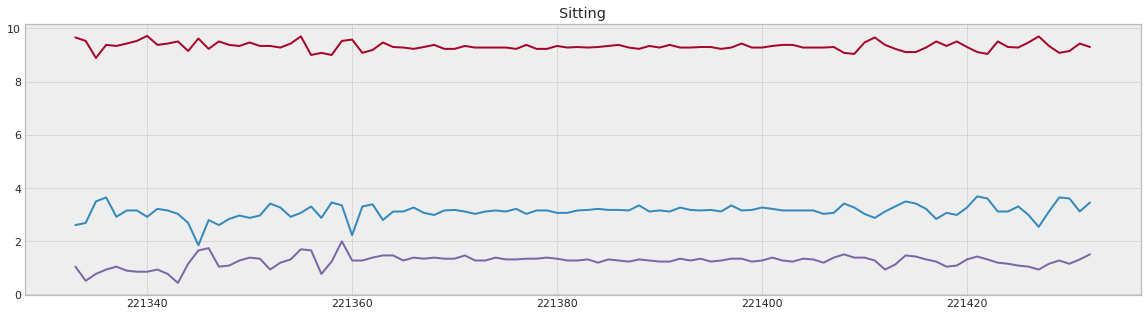

In [ ]:
n_samples=data_rep(5) #5 seconds
plt.figure(figsize=(20,5))
plt.plot(sit['x-axis'][:n_samples])
plt.plot(sit['y-axis'][:n_samples])
plt.plot(sit['z-axis'][:n_samples])
plt.title('Sitting')

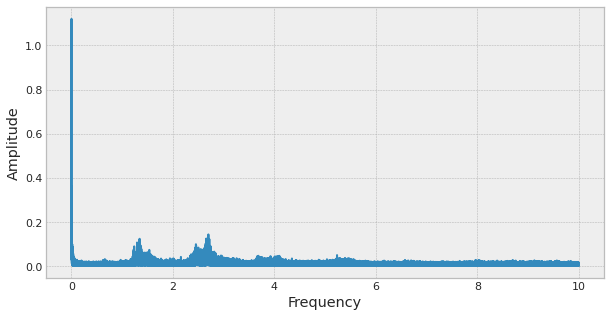

In [ ]:
jog_x_list=jog['x-axis'].tolist()
sit_x_list=sit['x-axis'].tolist()
fourierTransform = np.fft.fft(jog_x_list)/len(jog_x_list) 
fourierTransform = fourierTransform[range(int(len(jog_x_list)/2))] # Exclude sampling frequency
tpCount = len(jog_x_list)
values = np.arange(int(tpCount/2))
timePeriod = tpCount/20
frequencies = values/timePeriod
plt.figure(figsize=(10,5))
plt.plot(frequencies, abs(fourierTransform))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.savefig('fourier_jog.png')
plt.show()


#NHANES Dataset



PAXSTAT: Component status code with PAXSTAT=1 for records with data that are deemed reliable. A PAXSTAT=2 was used to code records that had some questionable data; analysts may wish to examine these records more closely.

PAXDAY: Day of the week; PAXDAY=1 for Sunday, 2 for Monday and so forth.

PAXN: Sequential observation number in minutes as recorded by the monitor device. The range begins with minute 1 on Day 1 (PAXN=1) and ends with the last minute of day 7 of monitor wear (PAXN=10080). Each day of wear produces 1440 individual minute records. The PAXN values for Day 1 range from 1 to 1440; Day 2 PAXN range from 1441-2880, and so forth.

PAXHOUR-hour of day the intensity data were recorded in military time or 24 hour clock.

PAXMINUT- minute value associated with a particular hour (PAXHOUR). The minute value shown is the start of the minute. For example, for the time 1201 hours, the start of the minute occurs at 1200 hours and PAXMINUT would be 00.

PAXINTEN is the intensity value recorded by the device. Each minute has an intensity value.

PAXCAL- Denotes whether the monitor was in calibration when it was returned by the subject. The data for monitors that were out of calibration (PMACAL=2) may be less reliable.

In [ ]:
df_c = pd.read_sas("drive/My Drive/Dataset/dataset/paxraw_c.xpt", format='xport')

In [ ]:
day_df = df_c[:1440]
week_df = df_c[10080:20160]
three_df = df_c[:4320]
month_df = df_c[40320:80640]
three_month_df = df_c[:120960]
year_df = df_c[:525600]

In [ ]:
three_month_df_reshaped = np.reshape(three_month_df['PAXINTEN'].to_numpy(), (1440,-1))
morning = three_month_df_reshaped[600:615,:]
noon = three_month_df_reshaped[720:735,:]
afternoon = three_month_df_reshaped[840:855,:]
evening = three_month_df_reshaped[1020:1035,:]
day = np.concatenate((morning, noon, afternoon, evening), axis=0)

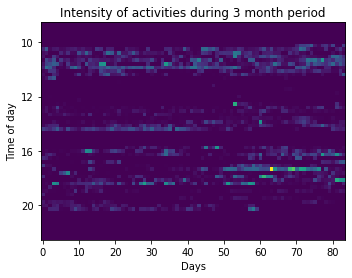

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(day)
h=[10,12,16,20]
ax.set_yticks([5,20,35,50])
ax.set_yticklabels(h)
ax.set_xlabel('Days')
ax.set_ylabel('Time of day')
ax.set_title('Intensity of activities during 3 month period')
plt.savefig('img.png')

#Data collected using Fitbit tracker

In [ ]:
import json

In [ ]:
with open('/content/steps-2020-08-21.json') as f:
  data = json.load(f)
df = pd.DataFrame.from_dict(data)
df[['date','time']] = df["dateTime"].str.split(" ", 1, expand=True)
df['day_number']=df.groupby('date').ngroup()
df['time'].astype(str)
df[['hours','minutes']] = df["time"].str.split(":", 1, expand=True)
df['minutes'].replace(':00','',regex=True,inplace=True)
df['hours']=df['hours'].astype(int)
df['minutes']=df['minutes'].astype(int)
df['value']=df['value'].astype(int)
df['oneday_time_mins']=df['hours']*60 + df['minutes']
df['overall_time_mins']=df['day_number']*24*60 + df['hours']*60 + df['minutes']
data = df.drop(["hours","minutes","dateTime"], axis=1)
data2 = df.groupby('day_number')
data2 = data2['value'].sum().to_frame('total').reset_index()
data2 = df.groupby('day_number')
data2 = data2['value'].sum().to_frame('total').reset_index()

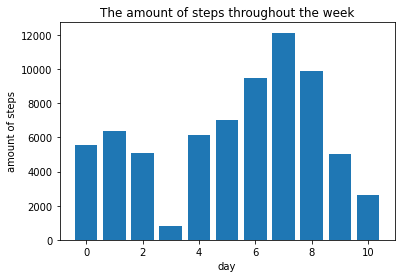

In [ ]:
plt.bar(data2['day_number'],data2['total']) 
plt.xlabel('day') 
plt.ylabel('amount of steps') 
plt.title('The amount of steps throughout the week') 
plt.show() 

In [ ]:
data3 = df[['value','day_number','oneday_time_mins']]
data3=data3.pivot(index='day_number', columns='oneday_time_mins', values='value')
data3[np.isnan(data3)] = 0


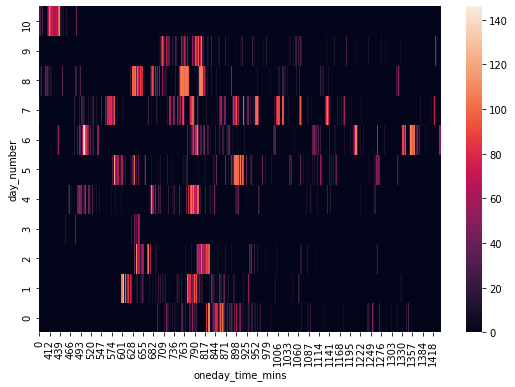

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data3)
ax.invert_yaxis()
plt.show()


In [ ]:
with open('/content/heart_rate-2020-08-30.json') as f:
  hrdata = json.load(f)
hrdf = pd.DataFrame.from_dict(hrdata)
hrdf[['date','time']] = hrdf["dateTime"].str.split(" ", 1, expand=True)
hrdf[['bpm','confidence']]=hrdf['value'].apply(pd.Series)
hrdf = hrdf.drop(['dateTime', 'value'], axis=1)
hrdf[['hours','minutes','seconds']] = hrdf["time"].str.split(":", 2, expand=True)
hrdf['hours']=hrdf['hours'].astype(int)
hrdf['minutes']=hrdf['minutes'].astype(int)
hrdf['seconds']=hrdf['seconds'].astype(int)
hrdf['overall_time_mins']= hrdf['hours']*60 + hrdf['minutes']
hrdf['overall_time_sec']=hrdf['hours']*60 + hrdf['minutes']*60+hrdf['seconds']

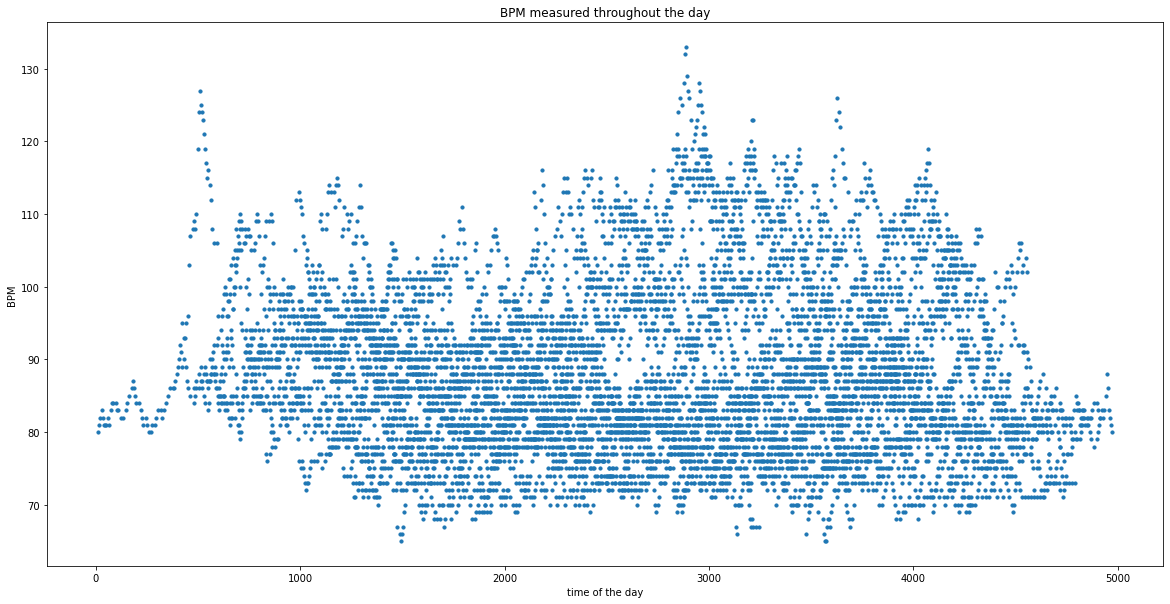

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(hrdf['overall_time_sec'],hrdf['bpm'], s=10) 
plt.xlabel('time of the day') 
plt.ylabel('BPM') 
plt.title('BPM measured throughout the day') 
plt.show() 

#Data collected using Axivity tracker





In [ ]:
columns = ['date and time', 'X-axis','Y-axis', 'Z-axis']
df1 = pd.read_csv('/content/xco', header=None, sep=',', names=columns)

In [ ]:
columns = ['date and time', 'X-axis','Y-axis', 'Z-axis']
df2 = pd.read_csv('/content/xcc', header=None, sep=',', names=columns)

In [ ]:
columns = ['date and time', 'X-axis','Y-axis', 'Z-axis']
df3 = pd.read_csv('/content/xaa', header=None, sep=',', names=columns)

In [ ]:
columns = ['date and time', 'X-axis','Y-axis', 'Z-axis']
df4 = pd.read_csv('/content/xcj', header=None, sep=',', names=columns)

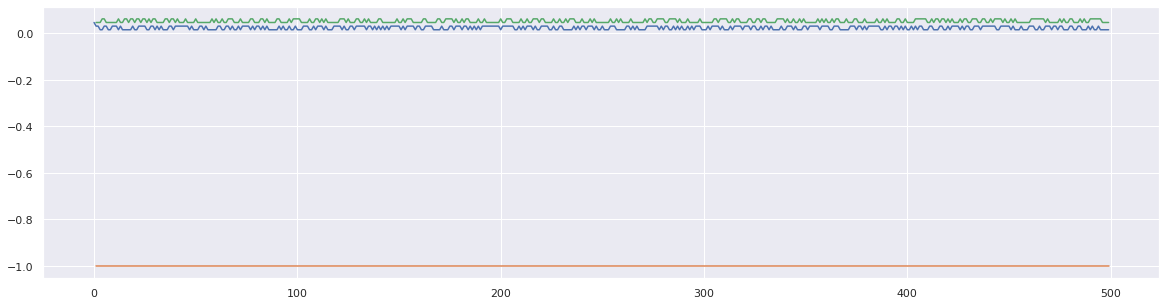

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df1['X-axis'][:500])
plt.plot(df1['Y-axis'][:500])
plt.plot(df1['Z-axis'][:500])

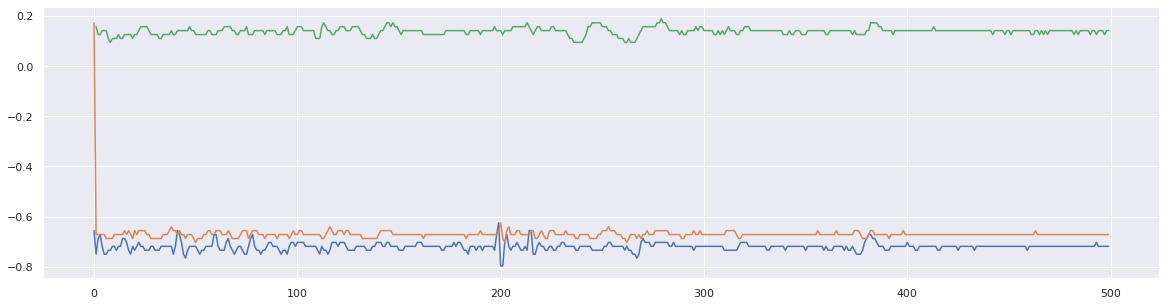

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df2['X-axis'][:500])
plt.plot(df2['Y-axis'][:500])
plt.plot(df2['Z-axis'][:500])

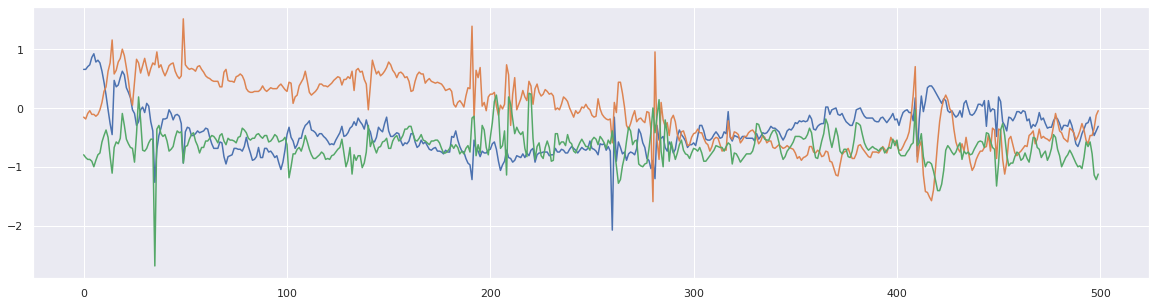

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df3['X-axis'][:500])
plt.plot(df3['Y-axis'][:500])
plt.plot(df3['Z-axis'][:500])

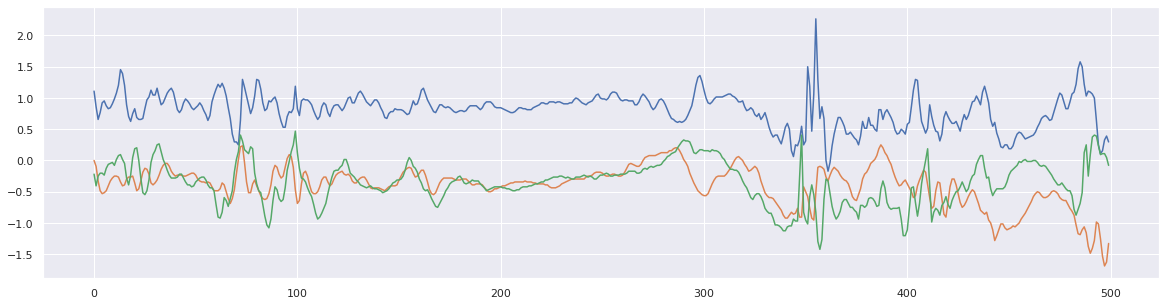

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df4['X-axis'][:500])
plt.plot(df4['Y-axis'][:500])
plt.plot(df4['Z-axis'][:500])